In [35]:
import os
import shutil
import time
import pickle
import imageio
import itertools
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import torch.optim as optim
from IPython.display import clear_output
from collections import OrderedDict
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

# I) Loading dataset / Preprocessing

In [36]:
is_gpu_available = torch.cuda.is_available()

In [37]:
def load_mnist():
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])
            
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    
    print(train_dataset)
    
    # Clear downloading message.
    clear_output()

    print("Image Shape: {}".format(train_dataset[0][0].numpy().shape), end = '\n\n')
    print("Training Set:   {} samples".format(len(train_dataset)))
    
    # Create iterator.
    train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    
    # Delete the data/ folder.
#     shutil.rmtree('./data')
    
    return train_loader

In [38]:
train_loader = load_mnist()

Image Shape: (1, 28, 28)

Training Set:   60000 samples


# II) Visualization

In [39]:
def plot_example(X, y, y_pred=None):
    """
        Plots 9 examples and their associate labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    """
    # Create figure with 3 x 3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
     
    X, y = X[:9, 0, ...], y[:9] 
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(X[i])

        # Show true and predicted classes.
        if y_pred is None:
            xlabel = "True: {0}".format(y[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

In [40]:
def plot_example_errors(X, y, y_pred):
    """
        Plots 9 example errors and their associate true/predicted labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    
    """
    incorrect = (y != y_pred)
 
    X = X[incorrect]
    y = y[incorrect]
    y_pred = y_pred[incorrect]

    # Plot the first 9 images.
    plot_example(X, y, y_pred)

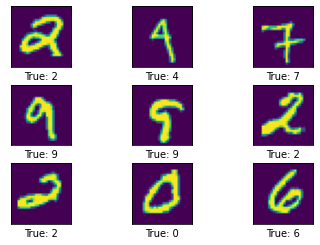

In [41]:
images, labels = iter(train_loader).next()
plot_example(images.numpy(), labels.numpy())

# III) Architecture build¶

## a) Generator

In [42]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.network = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(100, 256)),
            ('act1', nn.LeakyReLU(0.2)),
            ('fc2', nn.Linear(256, 512)),
            ('act2', nn.LeakyReLU(0.2)),
            ('fc3', nn.Linear(512, 1024)),
            ('act3', nn.LeakyReLU(0.2)),
            ('fc4', nn.Linear(1024, 28*28)),
            ('act4', nn.Tanh())
        ]))

#     def init_weights(self, mean, std):
#         for m in self._modules['network']:
#             if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
#                 m.weight.data.normal_(mean, std)
#                 m.bias.data.zero_()
    
    def forward(self, x):
        out = self.network(x)
        return out

In [43]:
torch.manual_seed(3)
G = Generator()
# G.init_weights(mean=0.0, std=0.02)
print("Model's state_dict:")

for param_tensor in G.state_dict():
    print(param_tensor, "\t", G.state_dict()[param_tensor].size())

torch.save(G.state_dict(), "G_params.pt")

Model's state_dict:
network.fc1.weight 	 torch.Size([256, 100])
network.fc1.bias 	 torch.Size([256])
network.fc2.weight 	 torch.Size([512, 256])
network.fc2.bias 	 torch.Size([512])
network.fc3.weight 	 torch.Size([1024, 512])
network.fc3.bias 	 torch.Size([1024])
network.fc4.weight 	 torch.Size([784, 1024])
network.fc4.bias 	 torch.Size([784])


In [44]:
dicG = torch.load('G_params.pt')
dicG

OrderedDict([('network.fc1.weight',
              tensor([[-0.0991, -0.0789, -0.0428,  ...,  0.0552, -0.0233, -0.0498],
                      [ 0.0170,  0.0416,  0.0106,  ...,  0.0236, -0.0453,  0.0947],
                      [-0.0659,  0.0650,  0.0543,  ...,  0.0820,  0.0407,  0.0693],
                      ...,
                      [-0.0578, -0.0492,  0.0445,  ...,  0.0769,  0.0498, -0.0680],
                      [ 0.0582,  0.0595, -0.0671,  ..., -0.0047,  0.0363,  0.0350],
                      [-0.0413, -0.0614, -0.0968,  ...,  0.0301,  0.0108,  0.0030]])),
             ('network.fc1.bias',
              tensor([-0.0675,  0.0613,  0.0120, -0.0756, -0.0404, -0.0140, -0.0106,  0.0575,
                       0.0035,  0.0881, -0.0532, -0.0741, -0.0824, -0.0509,  0.0055,  0.0754,
                       0.0783, -0.0544,  0.0780,  0.0182, -0.0371,  0.0321,  0.0308,  0.0956,
                      -0.0789,  0.0285,  0.0446,  0.0753,  0.0087, -0.0695, -0.0232, -0.0474,
                    

## b) Discriminator

In [45]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.network = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(28*28, 1024)),
            ('act1', nn.LeakyReLU(0.2)),
            ('drop1', nn.Dropout(0.3)),

            ('fc2', nn.Linear(1024, 512)),
            ('act2', nn.LeakyReLU(0.2)),
            ('drop2', nn.Dropout(0.3)),
            
            ('fc3', nn.Linear(512, 256)),
            ('act3', nn.LeakyReLU(0.2)),
            ('drop3', nn.Dropout(0.3)),
            
            ('fc4', nn.Linear(256, 1)),
            ('act4', nn.Sigmoid())       
        ]))
    
#     def init_weights(self, mean, std):
#         for m in self._modules['network']:
#             if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
#                 m.weight.data.normal_(mean, std)
#                 m.bias.data.zero_()

    def forward(self, x):
        out = self.network(x)
        return out

In [46]:
torch.manual_seed(3)
D = Discriminator()
# D.init_weights(mean=0.0, std=0.02)

print("Model's state_dict:")

for param_tensor in D.state_dict():
    print(param_tensor, "\t", D.state_dict()[param_tensor].size())

torch.save(D.state_dict(), "D_params.pt")

Model's state_dict:
network.fc1.weight 	 torch.Size([1024, 784])
network.fc1.bias 	 torch.Size([1024])
network.fc2.weight 	 torch.Size([512, 1024])
network.fc2.bias 	 torch.Size([512])
network.fc3.weight 	 torch.Size([256, 512])
network.fc3.bias 	 torch.Size([256])
network.fc4.weight 	 torch.Size([1, 256])
network.fc4.bias 	 torch.Size([1])


In [47]:
dicD = torch.load('D_params.pt')
dicD

OrderedDict([('network.fc1.weight',
              tensor([[-0.0354, -0.0282, -0.0153,  ...,  0.0311, -0.0222, -0.0265],
                      [-0.0316, -0.0153,  0.0043,  ...,  0.0247, -0.0167,  0.0203],
                      [-0.0146,  0.0174, -0.0178,  ...,  0.0204,  0.0098, -0.0299],
                      ...,
                      [ 0.0015,  0.0004, -0.0152,  ...,  0.0320,  0.0239, -0.0246],
                      [-0.0043,  0.0314, -0.0118,  ..., -0.0306, -0.0051, -0.0038],
                      [-0.0204, -0.0057, -0.0018,  ...,  0.0152,  0.0280, -0.0328]])),
             ('network.fc1.bias',
              tensor([ 0.0083, -0.0278, -0.0351,  ..., -0.0142,  0.0293, -0.0344])),
             ('network.fc2.weight',
              tensor([[-0.0026, -0.0292,  0.0294,  ..., -0.0132, -0.0090, -0.0258],
                      [-0.0208,  0.0228,  0.0241,  ..., -0.0134, -0.0188, -0.0234],
                      [ 0.0032,  0.0225, -0.0004,  ...,  0.0034,  0.0262, -0.0249],
                      .

## c) Optimizers & Loss

In [48]:
# Optimizers.
D_optimizer = optim.Adam(D.parameters(), lr=0.0002)
G_optimizer = optim.Adam(G.parameters(), lr=0.0002)

criterion = nn.BCELoss()

# Loss.
def real_loss(D_out, smooth=False):
    '''
        Calculates how close discriminator outputs are to being real.
        
        Params:
        -D_out: discriminator logits.
    '''
    batch_size = D_out.size(0)
    
    # label smoothing.
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1.

    if is_gpu_available:
        labels = labels.cuda()

    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''
        Calculates how close discriminator outputs are to being fake.
        
        Params:
        -D_out: discriminator logits.
    '''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0.
    
    if is_gpu_available:
        labels = labels.cuda()
    
    # Calculate loss.
    loss = criterion(D_out.squeeze(), labels)
    return loss

## d) Utility functions

In [49]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    G.eval()

    z_ = torch.randn((5*5, 100))

    if is_gpu_available:
        z_ = z_.cuda()
    
    test_images = G(z_)

    if is_gpu_available:
        G.train().cuda()
        D.train().cuda()
    else:
        G.train()
        D.train()


    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, :].cpu().data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

# results save folder
if not os.path.isdir('MNIST_GAN_results'):
    os.mkdir('MNIST_GAN_results')
if not os.path.isdir('MNIST_GAN_results/training_results'):
    os.mkdir('MNIST_GAN_results/training_results')

# IV) Training phase

In [50]:
def train():
    EPOCHS = 100
    
    if is_gpu_available:
        G.train().cuda()
    else:
        G.train()

    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []
        
    for epoch in range(EPOCHS):
        
        D_losses = []
        G_losses = []
        
        epoch_start_time = time.time()
        
        for i, (real_images, _) in enumerate(train_loader):
            
            batch_size = real_images.size(0)
            real_images = real_images.view(-1, 28 * 28)
                
            # ---------TRAIN THE DISCRIMINATOR ----------------
            D_optimizer.zero_grad()
            
            # 1. Train with real images.
            if is_gpu_available:
                real_images = real_images.cuda()
            
            # Compute the discriminator losses on real images
            # smooth the real labels.
            D_real = D(real_images)
            D_real_loss = real_loss(D_real, smooth=True)
            
            # 2. Train with fake images.
            # Generate fake images.
            z = torch.randn((batch_size, 100))
            
            if is_gpu_available:
                z = z.cuda()
            
            fake_images = G(z)
            
            # 3. Compute the discriminator losses on fake images.
            D_fake = D(fake_images)
            D_fake_loss = fake_loss(D_fake)
            
            # 4. Add up real and fake loss.
            D_loss = D_real_loss + D_fake_loss
            
            # 5. Perform backprop and optimization step.
            D_loss.backward()
            D_optimizer.step()
            
            D_losses.append(D_loss.item())
            
            # ---------TRAIN THE GENERATOR ----------------
            
            G_optimizer.zero_grad()
            
            # 1. Generate fake images.
            z = torch.randn((batch_size, 100))
            
            if is_gpu_available:
                z = z.cuda()
            
            fake_images = G(z)
            
            # 2. Compute the discriminator loss on fake images
            # using flipped labels.
            D_fake = D(fake_images)
            G_loss = real_loss(D_fake) # use real loss to flip labels.
            
            # 3. Perform backprop and optimization step.        
            G_loss.backward()
            G_optimizer.step()
            
            G_losses.append(G_loss.item())
        
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time
    
        # Print discriminator and generator loss.
        info = "[Epoch {}/{}] ({:0.3f}s): D_loss = {:0.6f} | G_loss = {:0.6f}"
        print(info.format(epoch+1, EPOCHS, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
        
        fixed_p = 'MNIST_GAN_results/training_results/MNIST_GAN_' + str(epoch + 1) + '.png'
        show_result(epoch+1, save=True, path=fixed_p)

        if G.training:
            print("G.train() = True")
        else:
            print("G.train() = False")

        train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
        train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
              
    print("Training finish!... save training results")
    torch.save(G.state_dict(), "MNIST_GAN_results/generator_param.pkl")
    torch.save(D.state_dict(), "MNIST_GAN_results/discriminator_param.pkl")
    
    with open('MNIST_GAN_results/train_hist.pkl', 'wb') as f:
        pickle.dump(train_hist, f)

    show_train_hist(train_hist, save=True, path='MNIST_GAN_results/MNIST_GAN_train_hist.png')

    images = []
    for e in range(EPOCHS):
        img_name = 'MNIST_GAN_results/training_results/MNIST_GAN_' + str(e + 1) + '.png'
        images.append(imageio.imread(img_name))
    
    imageio.mimsave('MNIST_GAN_results/generation_animation.gif', images, fps=5)

In [51]:
train()

[Epoch 1/100] (84.248s): D_loss = 0.957793 | G_loss = 3.517175
G.train() = True
[Epoch 2/100] (82.616s): D_loss = 0.911195 | G_loss = 3.591245
G.train() = True
[Epoch 3/100] (84.813s): D_loss = 1.071833 | G_loss = 1.807441
G.train() = True
[Epoch 4/100] (82.654s): D_loss = 0.942806 | G_loss = 2.421868
G.train() = True
[Epoch 5/100] (86.055s): D_loss = 0.825946 | G_loss = 2.886307
G.train() = True
[Epoch 6/100] (82.398s): D_loss = 0.821066 | G_loss = 2.969386
G.train() = True
[Epoch 7/100] (82.734s): D_loss = 0.828064 | G_loss = 2.633387
G.train() = True
[Epoch 8/100] (82.315s): D_loss = 0.792340 | G_loss = 2.801725
G.train() = True
[Epoch 9/100] (81.168s): D_loss = 0.794331 | G_loss = 2.837683
G.train() = True
[Epoch 10/100] (81.111s): D_loss = 0.797882 | G_loss = 2.860833
G.train() = True
[Epoch 11/100] (81.481s): D_loss = 0.787515 | G_loss = 2.919374
G.train() = True
[Epoch 12/100] (81.602s): D_loss = 0.807969 | G_loss = 2.762748
G.train() = True
[Epoch 13/100] (81.040s): D_loss = 0.

/home/sphird/.virtualenvs/pytorch/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
